# LAB 6 - PART 2 (with our own image)

# Group Members:

* Name 1 : **Leticia Martín Cabrera - 230781**
 
* Name 2 : **Júlia Ruiz Valero - 230308**

**Goal of the practical session**:

<font color="blue"> In this part of the practical session we will apply the algorithm to our image.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/LAB6_optimization"

/content/drive/MyDrive/LAB6_optimization


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import os
import sys

In [ ]:
# Read the image
images_dir = os.path.abspath(os.path.join(os.getcwd(), "images"))
image_real = np.array(Image.open(os.path.join(images_dir, "tropical.jpg"))).astype(np.int16)[:,:,0]
np.random.seed(4)
image_noisy = image_real + 20 * np.random.uniform(high = 50, size = image_real.shape)

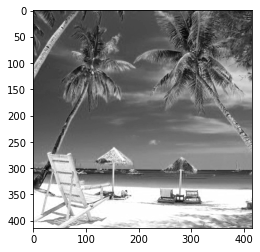

In [ ]:
plt.imshow(image_real, cmap = "gray" )

In [ ]:
def im_fwd_gradient(image: np.matrix):
    """
    Discrete gradient of an image using forward differences, with homogeneous Neuman boundary conditions.

    :param u: image (MxN)
            
    :return gradu_j: partial derivative in the j (rows) direction (also x direction)
    :return gradu_i: partial derivative in the i (cols) direction (also y direction)
    """
    # Get the size of the image
    image_shape = image.shape
    
    # Calculate both gradients
    gradu_j = np.append(np.diff(image, axis = 1), np.zeros((image_shape[0], 1)), axis = 1)
    gradu_i = np.append(np.diff(image, axis = 0), np.zeros((1, image_shape[1])), axis = 0)
    return gradu_i, gradu_j

def im_bwd_divergence(gradient_i: np.matrix,
                      gradient_j: np.matrix):
    """
    Discrete divergence of a vector field using backwards differences. 
    This is the negative transpose of the im_fwd_gradient
    
    :param gradient_i: component of g in the direction j (rows) (also x direction)
    :param gradient_j: component of g in the direction i (cols) (also y direction)
    
    :return divg: backwards divergence of g
    """
    # Backwards j partial derivative of gradient_j
    gradient_j[:, gradient_j.shape[1] - 1] = 0
    divg = np.diff(np.append(np.zeros((gradient_j.shape[0], 1)), gradient_j, axis = 1), axis = 1)
    
    # Backwards i partial derivative of gradient_i
    gradient_i[gradient_i.shape[0] - 1, :] = 0
    divg = np.diff(np.append(np.zeros((1, gradient_i.shape[1])), gradient_i, axis = 0), axis = 0) + divg
    
    return divg

## **1. Complete the function rof_primal_dual. Follow the comments provided in the code.**

In [ ]:
def rof_primal_dual(f: np.matrix, 
                    lambda_: float, 
                    pd_prms: dict,
                    fig, 
                    ax1, 
                    ax2):
    # Get the params
    max_iters = pd_prms.get("max_iters")
    tolerance = pd_prms.get("tolerance")
    delta     = pd_prms.get("delta")
    theta     = pd_prms.get("theta")
    sz = f.shape # M = sz(1), N = sz(2)

    # initialize primal variable
    u = f

    # initialize dual variable (a vector valued image)
    p_j = np.zeros(sz)
    p_i = np.zeros(sz)
    div_p = im_bwd_divergence(p_i, p_j)

    # grad of f, needed later
    gf_i, gf_j = im_fwd_gradient(f)

    # vectors with function values
    fps = []
    fds = []

    it = 0
    dual_gap = np.inf
    while (dual_gap > tolerance) and (it < max_iters):

        # Update the iteration counter
        it += 1

        # TODO: update primal variable with a gradient descent step
        u = u - theta * ((1/lambda_) * (u-f)- div_p)

        # update gradient of primal variable
        gu_i, gu_j = im_fwd_gradient(u)

        # TODO: update dual variable - gradient ascent
        p_j = p_j + delta * gu_j
        p_i = p_j + delta * gu_i

        # TODO: project over the feasible set
        # HINT: For each k,l p_i(k,l) and p_j(k,l) are the i and j components of a
        # two dimensional vector p(k,l) = [p_i(k,l), p_j(k,l)] this vector needs
        # to have norm less or equal than 1. This is done by dividing p(k,l) by
        #
        # max{1,|p(k,l)|},   where    |p(k,l)| = sqrt(p_i(k,l)^2 + p_j(k,l)^2)
        # 
        # Try to do this using matrix operations
        divisor = np.maximum (np.ones(sz), np.sqrt(np.power(p_i,2) + np.power(p_j,2)))
        p_j = p_j / divisor
        p_i = p_i / divisor
        
        # TODO: update divergence of dual variable p (remember, p has been projected in the previous lines)
        div_p = im_bwd_divergence(p_i, p_j)

        # primal energy
        PE = np.sqrt(np.power(gu_j, 2) + np.power(gu_i, 2)).sum()
        PE = PE + 1/2 / lambda_ * np.power(u - f, 2).sum()

        # TODO: dual energy
        DE = (gf_i * p_i + gf_j * p_j).sum() - (lambda_/2) * np.power (div_p,2).sum() 

        # we normalize the energies between the number of pixels
        PE = PE / np.prod(sz) 
        DE = DE / np.prod(sz)

        # dual gap
        dual_gap = PE - DE

        fps.append(PE)
        fds.append(DE)
        
        # Plot
        if it % 10 == 0:
            # display primal and dual variable
            ax1.imshow(u, cmap = "gray")
            ax2.imshow(np.concatenate((p_i, p_j), axis = 1), cmap = "gray")
            clear_output(wait=True)
            display(fig) 
            
            # display information - dual gap
            print("[it {0} of {1}] DG = {2} - {3} = {4}".format(it, max_iters, PE, DE, dual_gap))

    return fps, fds

#### **Run the primal dual**

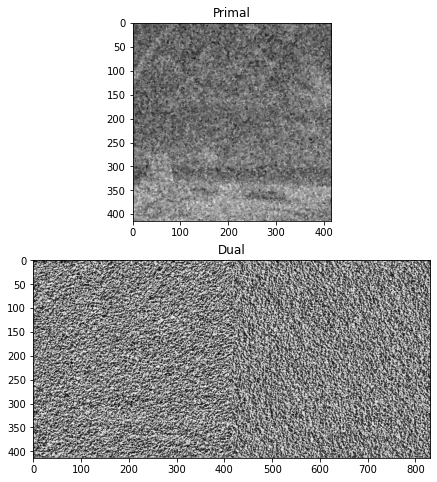

[it 500 of 500] DG = 166.4012440000332 - 123.9218879242617 = 42.47935607577149


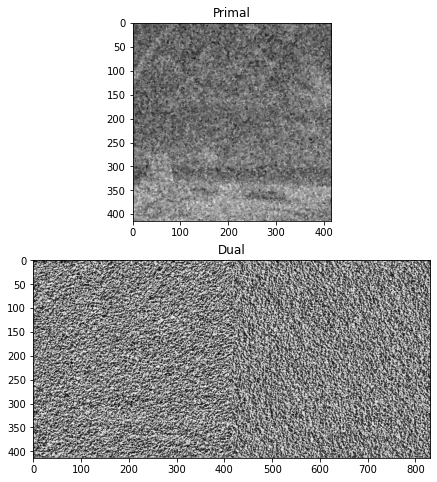

In [ ]:
# Define the parameters
lambda_ = 300
pd_prms = {"max_iters": 500,
            "tolerance": 1e-4,
            "delta": 1/2,
            "theta": 1/2
           }

# Build up the plot
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (14, 8))
ax1.set_title("Primal")
ax2.set_title("Dual")

# Run the primal dual
fps, fds = rof_primal_dual(image_noisy, lambda_, pd_prms, fig, ax1, ax2)

## **2. Complete the function rof_dual. Follow the comments provided in the code.**

In [ ]:
def rof_dual(f: np.matrix, 
             lambda_: float, 
             pd_prms: dict,
             fig, 
             ax1, 
             ax2):
    # Get the params
    max_iters = pd_prms.get("max_iters")
    tolerance = pd_prms.get("tolerance")
    delta     = pd_prms.get("delta")
    sz = f.shape # M = sz(1), N = sz(2)

    # initialize dual variable (a vector valued image)
    p_j = np.zeros(sz)
    p_i = np.zeros(sz)
    div_p = im_bwd_divergence(p_i, p_j)

    # grad of f, needed later
    gf_i, gf_j = im_fwd_gradient(f)

    # vectors with function values
    fps = []
    fds = []

    it = 0
    dual_gap = np.inf
    while (dual_gap > tolerance) and (it < max_iters):

        # Update the iteration counter
        it += 1

        # TODO: update primal variable and its gradient - this is u^*(xi) for current xi 
        u_star = f + lambda_ * div_p

        # update gradient of primal variable
        gu_star_i, gu_star_j = im_fwd_gradient(u_star)

        # TODO: update dual variable - gradient ascent
        p_j = p_j + delta * gu_star_j
        p_i = p_i + delta * gu_star_i

        # TODO: project over the feasible set
        # HINT: For each k,l p_i(k,l) and p_j(k,l) are the i and j components of a
        # two dimensional vector p(k,l) = [p_i(k,l), p_j(k,l)] this vector needs
        # to have norm less or equal than 1. This is done by dividing p(k,l) by
        #
        # max{1,|p(k,l)|},   where    |p(k,l)| = sqrt(p_i(k,l)^2 + p_j(k,l)^2)
        # 
        # Try to do this using matrix operations
        proj = np.maximum (np.ones(sz), np.sqrt(np.power(p_i,2) + np.power(p_j,2)))
        p_j = p_j / proj
        p_i = p_i / proj

        # TODO: update divergence of dual
        div_p = im_bwd_divergence(p_i, p_j)

        # primal energy
        PE = np.sqrt(np.power(gu_star_j, 2) + np.power(gu_star_i, 2)).sum()
        PE = PE + 1/2 / lambda_ * np.power(u_star - f, 2).sum()

        # TODO: dual energy
        DE = (gf_i * p_i + gf_j * p_j).sum() - (lambda_/2) * np.power(div_p,2).sum() 

        # we normalize the energies between the number of pixels
        PE = PE / np.prod(sz) 
        DE = DE / np.prod(sz)

        # dual gap
        dual_gap = PE - DE

        fps.append(PE)
        fds.append(DE)
        
        # Plot
        if it % 10 == 0:
            # display primal and dual variable
            ax1.imshow(u_star, cmap = "gray")
            ax2.imshow(np.concatenate((p_i, p_j), axis = 1), cmap = "gray")
            clear_output(wait=True)
            display(fig) 
            
            # display information - dual gap
            print("[it {0} of {1}] DG = {2} - {3} = {4}".format(it, max_iters, PE, DE, dual_gap))

    return fps, fds

#### **Run the dual**

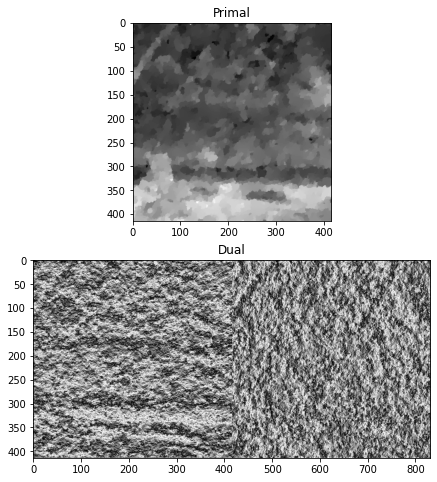

[it 500 of 500] DG = 140.50582022532723 - 140.36012549725007 = 0.1456947280771601


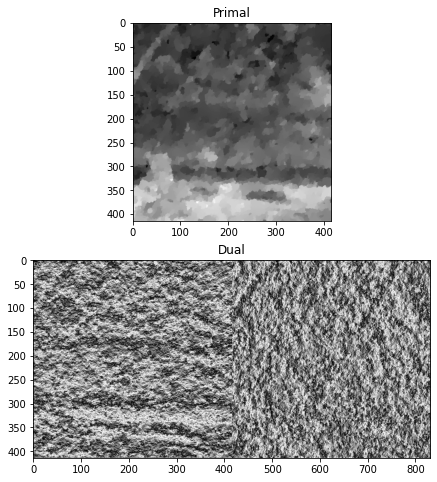

In [ ]:
# Define the parameters
lambda_ = 300
pd_prms = {"max_iters": 500,
            "tolerance": 1e-4,
            "delta": 1/4.5 / lambda_
           }

# Build up the plot
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (14, 8))
ax1.set_title("Primal")
ax2.set_title("Dual")

# Run the primal dual
fps, fds = rof_dual(image_noisy, lambda_, pd_prms, fig, ax1, ax2)

###**Our conclusions**:

  <font color="blue"> Indeed, as expected, we also observe that the image outputs change differently when we apply the primal-dual and when applying the dual algorithm.